<a href="https://colab.research.google.com/github/MHassaanButt/Antenna-design-using-ML/blob/main/Brain_Tumor_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain Tumor Detection Using Pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!scp -r "/content/drive/MyDrive/Datasets/BrainTumorDataset" "/content/"

In [ ]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

Data Prep For Pytorch Model

In [ ]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/content/BrainTumorDataset/Training/')
path_test = ('/content/BrainTumorDataset/Testing/')
img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [ ]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


Basic Visualization

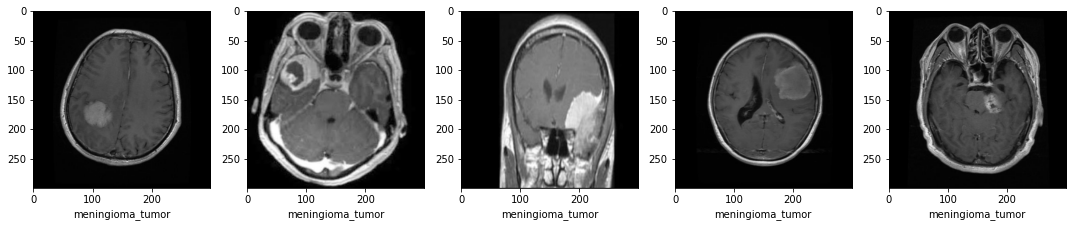

In [ ]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

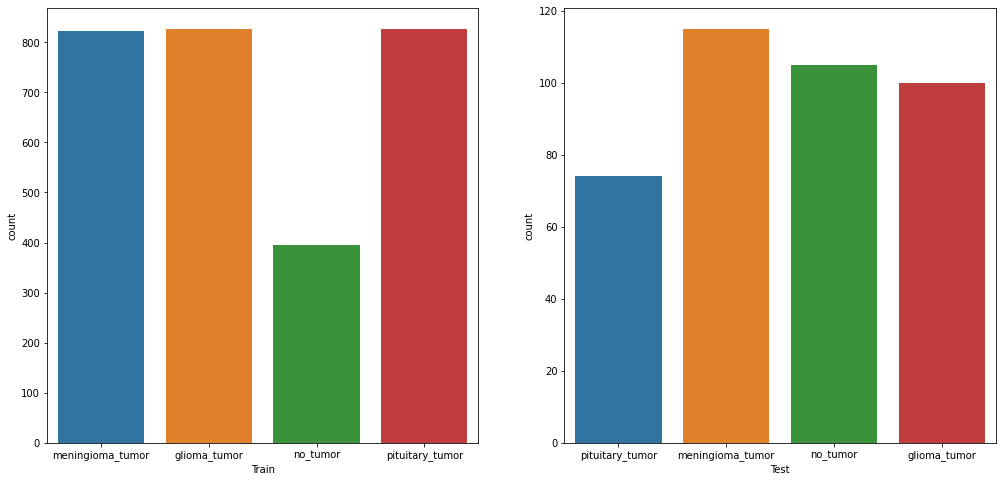

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

Data Prep For Pytorch Model

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape


((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

Transforming the images

In [ ]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [ ]:
train_path = ('/content/BrainTumorDataset/Training/')
test_path = ('/content/BrainTumorDataset/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transforming_img),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transforming_img),
    batch_size=32, shuffle=True
)


#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(f'The classes are: {classes}')


The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

Building Model Using Pytorch

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*75*75)
        output=self.fc(output)
            
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   
model=ConvNet(num_classes=4).to(device)

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

best_accuracy=0.0

for epoch in range(20):
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        # plt.imshow(outputs[i].numpy().astype("uint8"))
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(8.2350) Train Accuracy: 0.5885017421602787 Test Accuracy: 0.4010152284263959
Epoch: 1 Train Loss: tensor(1.4906) Train Accuracy: 0.7940766550522648 Test Accuracy: 0.5406091370558376
Epoch: 2 Train Loss: tensor(1.0998) Train Accuracy: 0.8501742160278746 Test Accuracy: 0.5862944162436549
Epoch: 3 Train Loss: tensor(0.6248) Train Accuracy: 0.8937282229965157 Test Accuracy: 0.6700507614213198
Epoch: 4 Train Loss: tensor(0.5003) Train Accuracy: 0.9121951219512195 Test Accuracy: 0.7081218274111675
Epoch: 5 Train Loss: tensor(0.3554) Train Accuracy: 0.9331010452961672 Test Accuracy: 0.6548223350253807
Epoch: 6 Train Loss: tensor(0.2502) Train Accuracy: 0.9529616724738676 Test Accuracy: 0.6142131979695431
Epoch: 7 Train Loss: tensor(0.3897) Train Accuracy: 0.9372822299651568 Test Accuracy: 0.7055837563451777
Epoch: 8 Train Loss: tensor(0.5653) Train Accuracy: 0.9090592334494774 Test Accuracy: 0.649746192893401
Epoch: 9 Train Loss: tensor(0.4602) Train Accuracy: 0.93

In [ ]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 2, figsize=(7,7))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

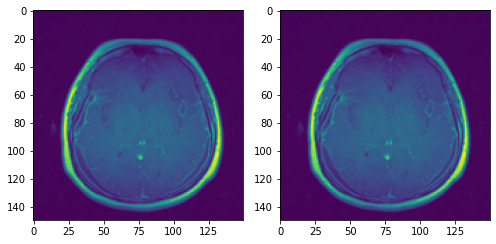

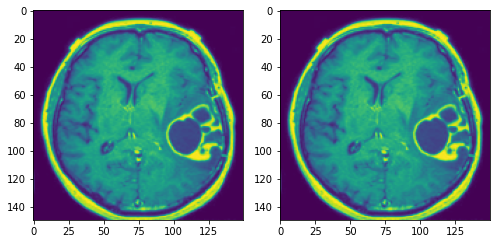

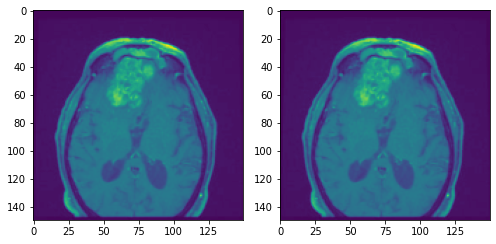

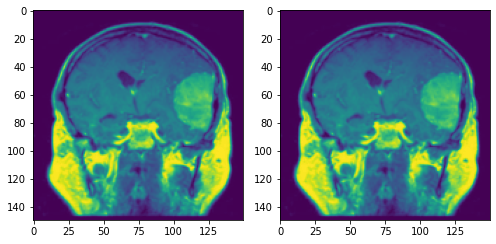

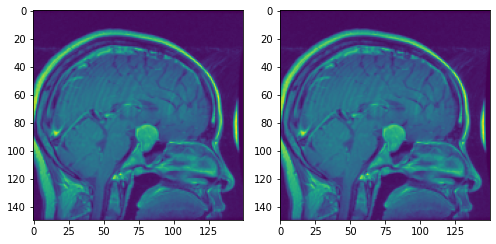

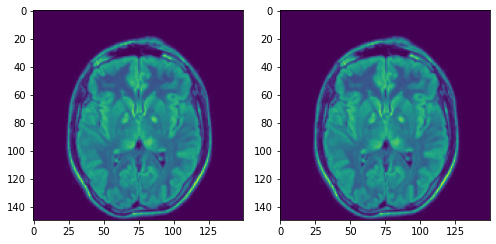

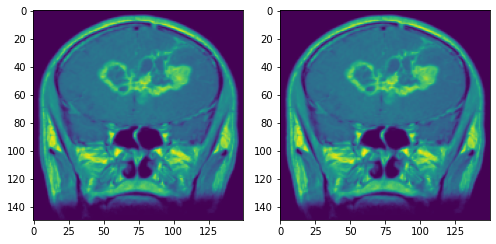

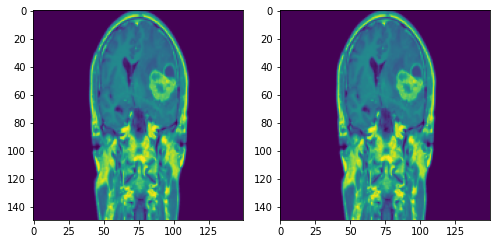

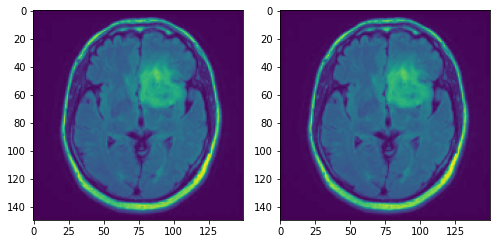

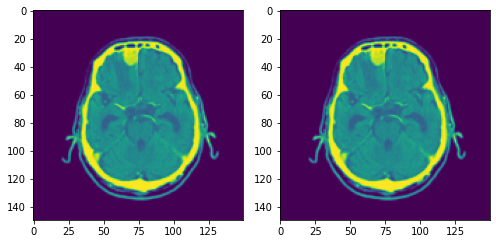

In [ ]:
# Plot a few training images
for j in range(len(images)):
  # mapping = {0:"NO",1:"Yes"}
  img_array = [images.cpu().detach().numpy()[j][0] for i in range(3)]
  # data,target = images,labels
  # pred = model.forward(data.float())

  # pred = torch.argmax(pred,dim=1)
  # plt.subplot(5,5,i+1)
  # plt.imshow(data[0][0].cpu())
  # plt.title(f"Actual : {mapping[target[0].cpu().detach().item()]} Prediction : {mapping[pred[0].cpu().detach().item()]}")
  plotImages(img_array)

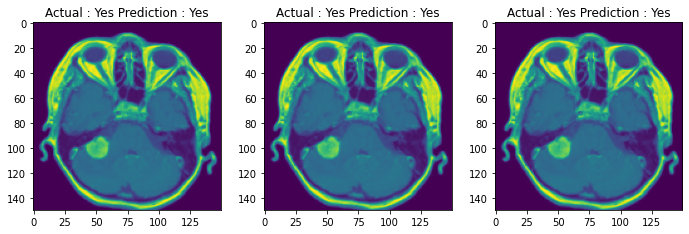

In [ ]:
for i, (images,labels) in enumerate(test_loader):
  if torch.cuda.is_available():
    images=Variable(images.cuda())
    labels=Variable(labels.cuda())
            
    outputs=model(images)
    # plt.imshow(outputs[i].numpy().astype("uint8"))
    _,prediction=torch.max(outputs.data,1)
mapping = {0:"NO",1:"Yes"}
fig = plt.figure(figsize=(20,20))


for i in range(3):
  data,target = images,labels
  pred = model.forward(data.float())

  pred = torch.argmax(pred,dim=1)
  plt.subplot(5,5,i+1)
  plt.imshow(data[0][0].cpu())
  plt.title(f"Actual : {mapping[target[0].cpu().detach().item()]} Prediction : {mapping[pred[0].cpu().detach().item()]}")